In [1]:
#Загрузим библиотеки и данные
from pandas import Series
import pandas as pd
import numpy as np

from datetime import datetime, timedelta


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train['Train'] = 1 # помечаем где у нас тренировочный
test['Train'] = 0 # помечаем где у нас тестовый


df = train.append(test, sort=False).reset_index(drop=True) # объединяем
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


# Предобработка данных

## Категоризация признаков

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Классифицируем переменные на три категории: бинарные, категориальные и числовые. Образование отнесем к числовым, так как категории можно представить по возрастанию. 
Также преобразуем признак app_date в дату и представим в виде дней недели, так как остальные признаки (месяцы и годы) даны в ограниченном виде.  

In [3]:
#Классифицируем переменные: 
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekend']
# Категориальные переменные
cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'month']
# Числовые переменные
num_cols = ['education', 'age', 'bki_request_cnt', 'decline_app_cnt', 'score_bki','region_rating','income']

Обработаем app_date

In [4]:
df['date']= pd.to_datetime(df['app_date'])
df['month']=df.date.dt.month
df['weekday']=df.date.dt.weekday
def weekend(i):
    if i == 0 or i ==1 or i == 2 or i == 3 or i == 4:
        return 0 
    elif i == 5 or i == 6:
        return 1

    
df['weekend']=df['weekday'].apply(weekend)
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,Train,date,month,weekday,weekend
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,18000,4,1,N,0.0,1,2014-02-01,2,5,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,19000,4,1,N,0.0,1,2014-03-12,3,2,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,30000,1,4,Y,0.0,1,2014-02-01,2,5,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,10000,1,3,N,0.0,1,2014-01-23,1,3,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,30000,1,4,Y,0.0,1,2014-04-18,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,...,15000,4,1,N,NaN,0,2014-03-31,3,0,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,...,200000,1,4,N,NaN,0,2014-04-25,4,4,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,...,60000,4,2,N,NaN,0,2014-03-30,3,6,1
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,...,30000,1,1,N,NaN,0,2014-01-07,1,1,0


In [5]:
#Обработаем образование
def educ(i):
    if i == 'SCH':
        return 1 
    elif i == 'UGR':
        return 2
    elif i== 'GRD':
        return 3
    elif i== 'PGR':
        return 4    
    elif i == 'ACD':
        return 5
    else:
        return 0

    
df.education=df['education'].apply(educ)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  object        
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

## Числовые признаки

Визуализируем числовые признаки и посмотрим их распределение относительно целевой переменной

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


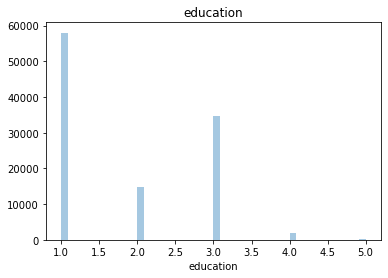

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


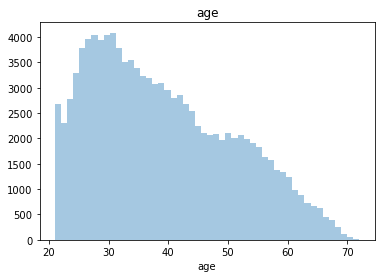

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


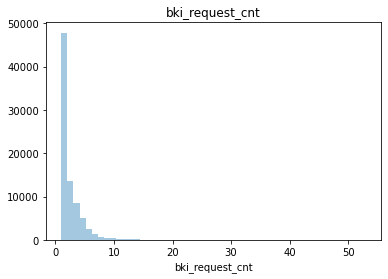

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


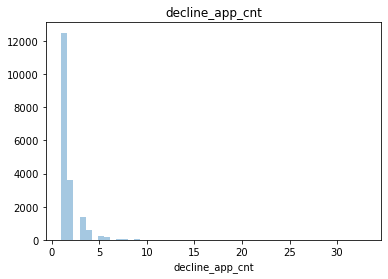

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


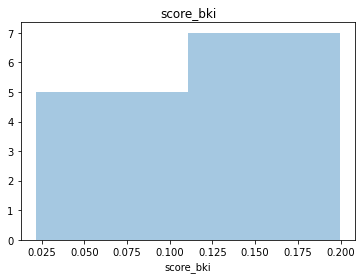

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


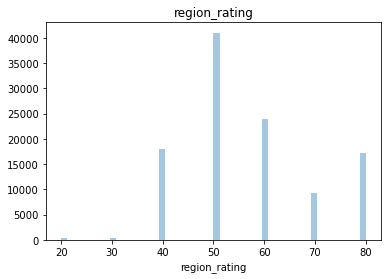

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


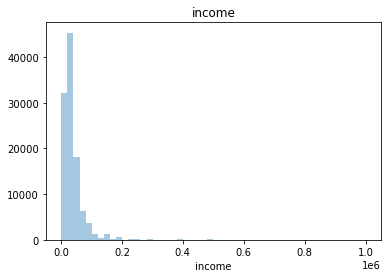

In [7]:
for i in num_cols:
    plt.figure(facecolor='white')
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

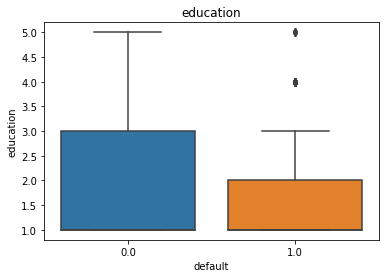

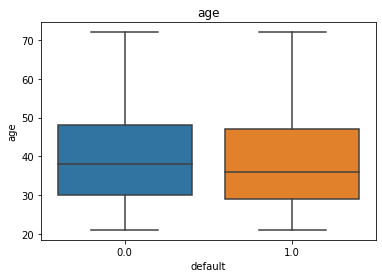

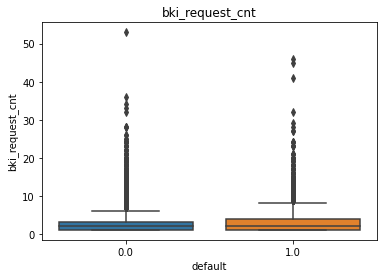

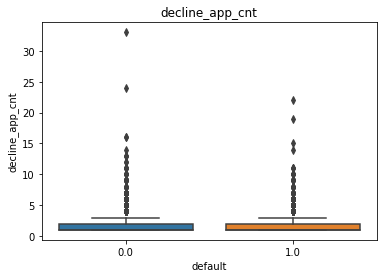

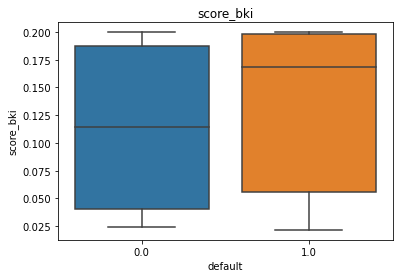

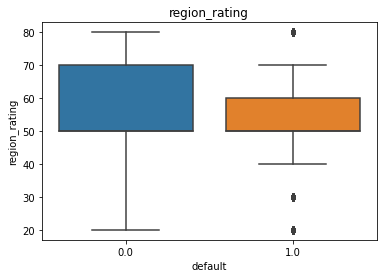

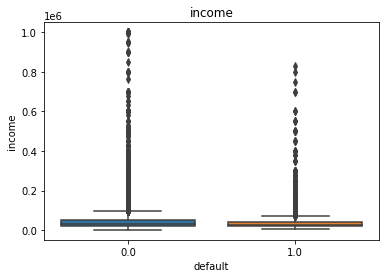

In [8]:
for i in num_cols:
    plt.figure(facecolor='white')
    sns.boxplot(x = df.default.dropna(),y=df[i][df[i] > 0].dropna())
    plt.title(i)
    plt.show()


Тяжелый правый хвост переменных age, bki, decline_app_cnt уберем с помощью логорифмирования, доход преобразуем в категории, потому что логарифмирование не решит проблему выбросов. 
Создадим по 3 новых признака no_decline, few_declines, many_declines и добавим их в бинарные переменные на основе decline_app и bki


In [9]:
df.decline_app_cnt.value_counts()


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [10]:

df['no_decline'] = df['decline_app_cnt'].apply(lambda x: 1 if x ==0 else 0)
df['few_declines'] = df['decline_app_cnt'].apply(lambda x: 1 if x ==1 or x == 2 else 0)
df['many_declines'] = df['decline_app_cnt'].apply(lambda x: 1 if x >=3 else 0)


In [11]:
df.bki_request_cnt.value_counts()
df['no_bki_request'] = df['bki_request_cnt'].apply(lambda x: 1 if x ==0 else 0)
df['few_bki_requests'] = df['bki_request_cnt'].apply(lambda x: 1 if x ==1 or x == 2 else 0)
df['many_bki_requests'] = df['bki_request_cnt'].apply(lambda x: 1 if x >=3 else 0)

In [12]:
df.sample(n=5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,date,month,weekday,weekend,no_decline,few_declines,many_declines,no_bki_request,few_bki_requests,many_bki_requests
99472,4786,11JAN2014,1,M,58,N,N,0,0,-2.110250,...,2014-01-11,1,5,1,1,0,0,0,0,1
96510,37458,13FEB2014,1,F,28,N,N,1,0,-1.963063,...,2014-02-13,2,3,0,0,1,0,0,1,0
87878,73215,20MAR2014,2,F,27,Y,N,1,0,-1.246591,...,2014-03-20,3,3,0,0,1,0,0,1,0
34387,65538,14MAR2014,1,M,48,N,N,0,0,-2.163738,...,2014-03-14,3,4,0,1,0,0,0,0,1
67560,34218,10FEB2014,1,M,36,N,N,0,0,-2.227876,...,2014-02-10,2,0,0,1,0,0,0,1,0


In [13]:
df.age=df.age.apply(lambda x: np.log(x))
df.bki_request_cnt=df.bki_request_cnt.apply(lambda x: np.log(x) if x >0 else x)
df.decline_app_cnt=df.decline_app_cnt.apply(lambda x: np.log(x) if x >0 else x)

def income(i):
    if i<=20000:
        return 1
    elif i>20000 and i<30000:
        return 2
    elif i>=30000 and i<40000:
        return 3
    elif i>=40000 and i<50000:
        return 4
    elif i>=50000 and i<100000:
        return 5
    elif i>=100000:
        return 6
    else:
        return 0
    
df['score_bki'] = df['score_bki'].abs()    
df['income']=df.income.apply(income)
df.income.value_counts()


1    31975
3    20564
5    20526
2    17430
4    12932
6     6721
Name: income, dtype: int64

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


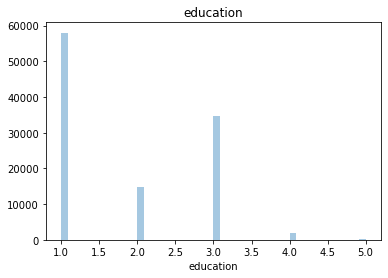

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


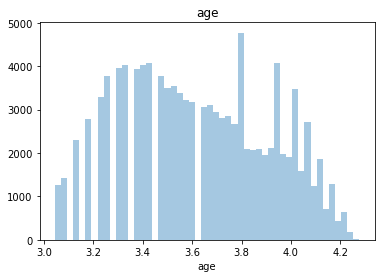

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


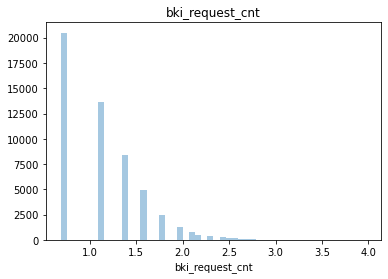

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


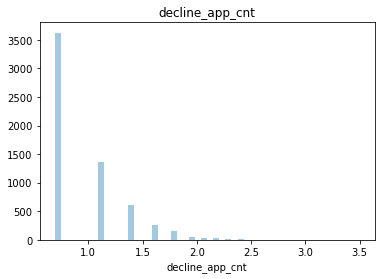

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


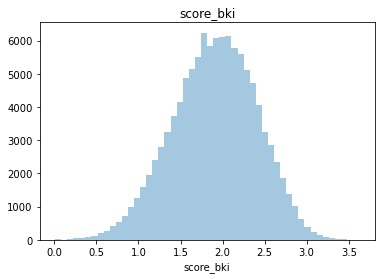

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


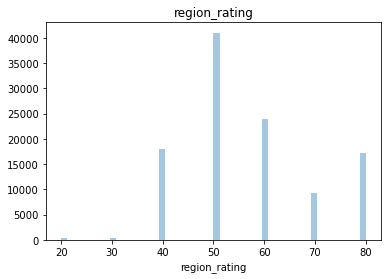

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


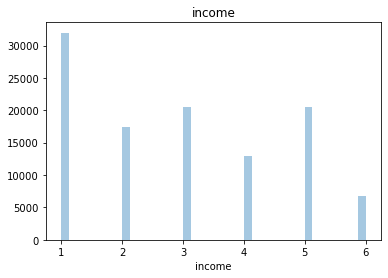

In [14]:
#Посмотрим, что получилось 
for i in num_cols:
    plt.figure(facecolor='white')
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

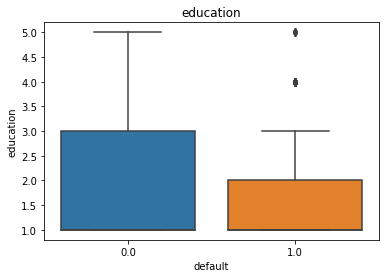

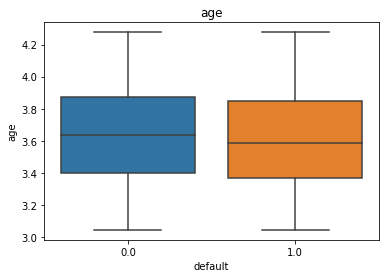

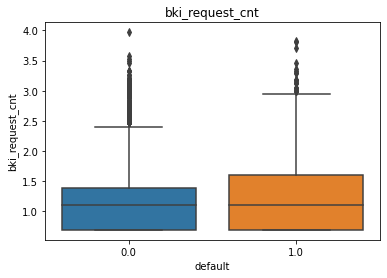

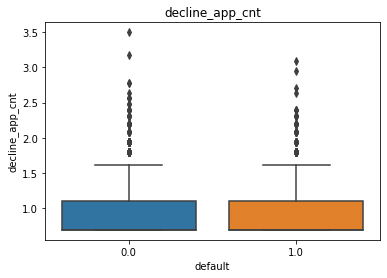

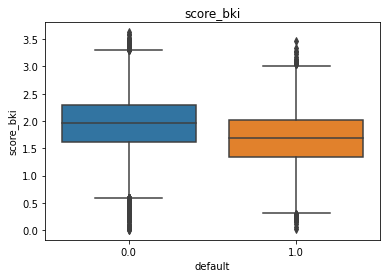

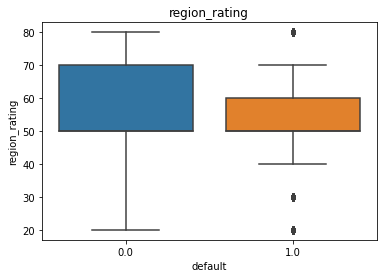

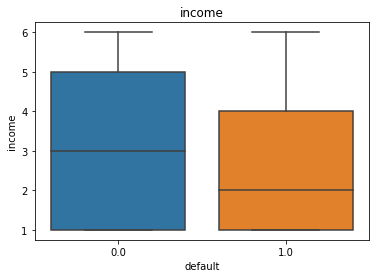

In [15]:
for i in num_cols:
    plt.figure(facecolor='white')
    sns.boxplot(x = df.default.dropna(),y=df[i][df[i] > 0].dropna())
    plt.title(i)
    plt.show()

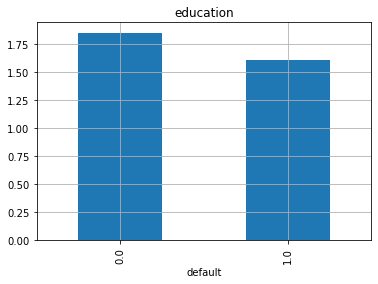

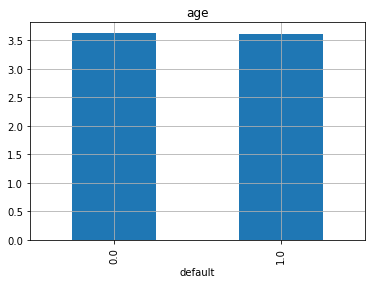

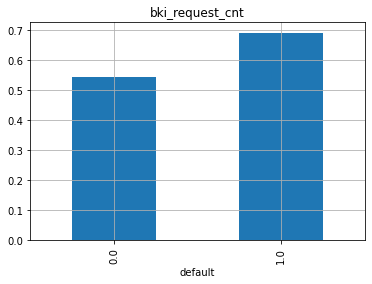

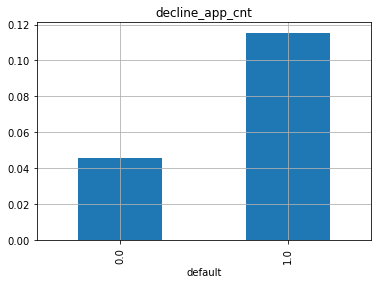

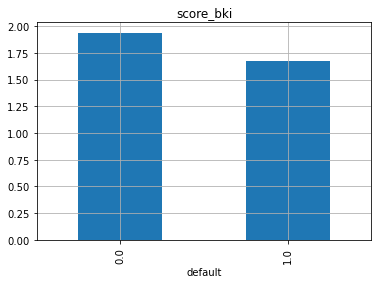

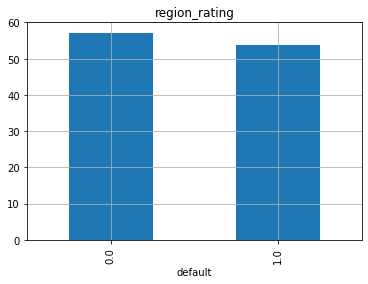

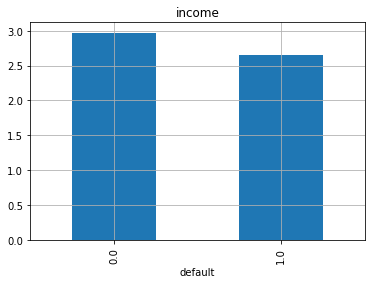

In [16]:


for i in num_cols:
    plt.figure(facecolor='white')
    df.groupby(by=['default'])[i].mean().plot(kind='bar',grid=True)
    plt.title(i)
    plt.show()

<AxesSubplot:>

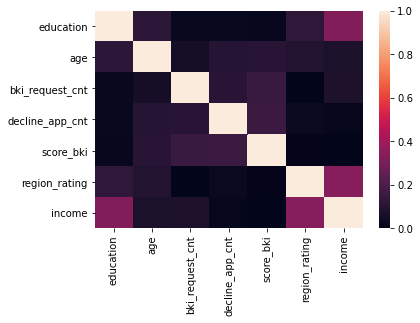

In [17]:
#Посмотрим корреляцию признаков
plt.figure(facecolor='white')
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [18]:
df[num_cols].describe()

,education,age,bki_request_cnt,decline_app_cnt,score_bki,region_rating,income
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,1.822212,3.627212,0.563349,0.053731,1.904561,56.751189,2.934334
std,0.958883,0.292797,0.661079,0.237948,0.499297,13.065923,1.651388
min,0.000000,3.044522,0.000000,0.000000,0.006805,20.000000,1.000000
25%,1.000000,3.401197,0.000000,0.000000,1.567888,50.000000,1.000000
50%,1.000000,3.610918,0.000000,0.000000,1.920823,50.000000,3.000000
75%,3.000000,3.871201,1.098612,0.000000,2.260434,60.000000,4.000000
max,5.000000,4.276666,3.970292,3.496508,3.624586,80.000000,6.000000


In [19]:
df[num_cols].corr()

,education,age,bki_request_cnt,decline_app_cnt,score_bki,region_rating,income
education,1.000000,-0.118582,0.022717,-0.022848,0.018124,0.124412,0.325503
age,-0.118582,1.000000,0.056648,-0.100255,0.109283,-0.090649,-0.070663
bki_request_cnt,0.022717,0.056648,1.000000,0.106054,-0.149110,-0.002659,0.078090
decline_app_cnt,-0.022848,-0.100255,0.106054,1.000000,-0.153185,-0.030096,-0.012178
score_bki,0.018124,0.109283,-0.149110,-0.153185,1.000000,-0.007143,0.001986
region_rating,0.124412,-0.090649,-0.002659,-0.030096,-0.007143,1.000000,0.338614
income,0.325503,-0.070663,0.078090,-0.012178,0.001986,0.338614,1.000000


Корреляция на достаточно низком уровне, что хорошо для регрессии
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

<AxesSubplot:>

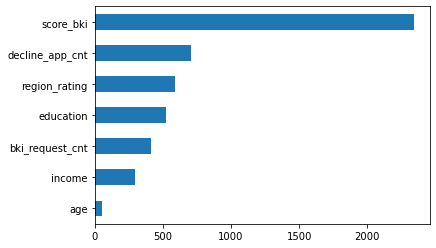

In [20]:
df1=df.dropna()
imp_num = Series(f_classif(df1[num_cols], df1['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Бинарные переменные

In [21]:
#'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekend'

In [22]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()



,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,date,month,weekday,weekend,no_decline,few_declines,many_declines,no_bki_request,few_bki_requests,many_bki_requests
0,25905,01FEB2014,1,1,4.127134,1,1,0.000000,0,2.008753,...,2014-02-01,2,5,1,1,0,0,0,1,0
1,63161,12MAR2014,1,0,4.077537,0,0,0.000000,0,1.532276,...,2014-03-12,3,2,0,1,0,0,0,0,1
2,25887,01FEB2014,1,1,3.218876,1,0,0.693147,0,1.408142,...,2014-02-01,2,5,1,0,1,0,0,1,0
3,16222,23JAN2014,1,0,3.970292,0,0,0.000000,0,2.057471,...,2014-01-23,1,3,0,1,0,0,0,1,0
4,101655,18APR2014,3,1,3.871201,0,0,0.000000,1,1.244723,...,2014-04-18,4,4,0,1,0,0,0,1,0


Добавим новые бинарные переменные

In [23]:
bin_cols=['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekend',
          'no_decline','few_declines', 'many_declines',
         'no_bki_request','few_bki_requests', 'many_bki_requests']

## Категориальные переменные

In [24]:
cat_cols

['home_address', 'work_address', 'sna', 'first_time', 'month']

<AxesSubplot:>

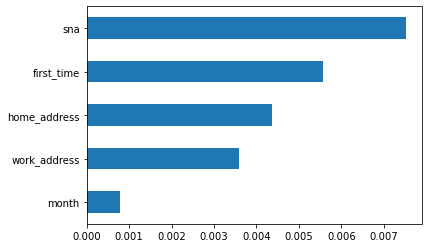

In [25]:
from sklearn.feature_selection import mutual_info_classif 
imp_cat = Series(mutual_info_classif(df1[cat_cols], df1['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
plt.figure(facecolor='white')
imp_cat.plot(kind = 'barh')

In [26]:
df.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

In [27]:
df[cat_cols].describe()

,home_address,work_address,sna,first_time,month
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,1.574945,2.497867,1.731588,2.765570,2.535107
std,0.527562,0.687651,1.122652,1.010151,1.087680
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000
50%,2.000000,3.000000,1.000000,3.000000,3.000000
75%,2.000000,3.000000,2.000000,4.000000,3.000000
max,3.000000,3.000000,4.000000,4.000000,4.000000


In [28]:
#Обработаем категориальные переменные с помощью OneHotEncoder
#Предварительно разделим данные на обучающие и тестовые
train_data = df[df['Train'] == 1]
test_data = df[df['Train'] == 0]
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

<AxesSubplot:>

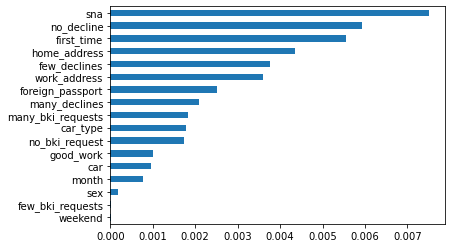

In [29]:

from sklearn.feature_selection import mutual_info_classif 
imp_cat = Series(mutual_info_classif(train_data[bin_cols + cat_cols], train_data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
plt.figure(facecolor='white')
imp_cat.plot(kind = 'barh')

In [30]:
#Удалим самые бесполезные признаки 
df=df.drop(['few_bki_requests','weekend'],axis=1)


## Создание и тестирование модели

In [31]:
#Стандартизируем числовые переменные
X_num_train = StandardScaler().fit_transform(train_data[num_cols].values)
X_num_test = StandardScaler().fit_transform(test_data[num_cols].values)

In [32]:
X = np.hstack([X_num_train, train_data[bin_cols].values, X_cat_train])
Y = train_data['default'].values

Разделим данные на тренировочную и тестовую часть и посчитаем логигистическую регрессию

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

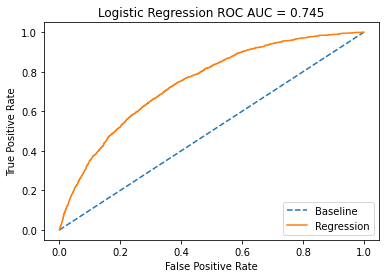

In [34]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_id          73799 non-null  int64         
 1   app_date           73799 non-null  object        
 2   education          73799 non-null  int64         
 3   sex                73799 non-null  int64         
 4   age                73799 non-null  float64       
 5   car                73799 non-null  int64         
 6   car_type           73799 non-null  int64         
 7   decline_app_cnt    73799 non-null  float64       
 8   good_work          73799 non-null  int64         
 9   score_bki          73799 non-null  float64       
 10  bki_request_cnt    73799 non-null  float64       
 11  region_rating      73799 non-null  int64         
 12  home_address       73799 non-null  int64         
 13  work_address       73799 non-null  int64         
 14  income

In [36]:
y_pred1 = model.predict(X_train)
f1_train = f1_score(y_train, y_pred1)
print('[train] F1-score = {:.2f}'.format(f1_train))
y_pred2 = model.predict(X_test)
f1_val = f1_score(y_test, y_pred2)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[train] F1-score = 0.06
[valid] F1-score = 0.04


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import cohen_kappa_score
y_pred3= model.predict(X_test)
acc=accuracy_score(y_test,y_pred3)
print('Accuracy = {:.2f}'.format(acc))

Accuracy = 0.87


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred3)

array([[12871,    62],
       [ 1785,    42]])

Мы видим хорошие показатели точности модели, но вот confusion matrix показывает, что на самом деле все плохо! У нас true posiive больше, чем возможно, и true negative почти нет! Надо сбалансировать модель!

In [39]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,default,Train,date,month,weekday,no_decline,few_declines,many_declines,no_bki_request,many_bki_requests
0,25905,01FEB2014,1,1,4.127134,1,1,0.000000,0,2.008753,...,0.0,1,2014-02-01,2,5,1,0,0,0,0
1,63161,12MAR2014,1,0,4.077537,0,0,0.000000,0,1.532276,...,0.0,1,2014-03-12,3,2,1,0,0,0,1
2,25887,01FEB2014,1,1,3.218876,1,0,0.693147,0,1.408142,...,0.0,1,2014-02-01,2,5,0,1,0,0,0
3,16222,23JAN2014,1,0,3.970292,0,0,0.000000,0,2.057471,...,0.0,1,2014-01-23,1,3,1,0,0,0,0
4,101655,18APR2014,3,1,3.871201,0,0,0.000000,1,1.244723,...,0.0,1,2014-04-18,4,4,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,1,0,3.610918,0,0,0.000000,0,1.744976,...,NaN,0,2014-03-31,3,0,0,1,0,0,1
110144,106254,25APR2014,3,0,4.158883,1,1,0.000000,0,2.293781,...,NaN,0,2014-04-25,4,4,1,0,0,0,1
110145,81852,30MAR2014,3,1,3.433987,0,0,0.693147,0,0.940752,...,NaN,0,2014-03-30,3,6,0,1,0,0,0
110146,1971,07JAN2014,2,0,3.295837,0,0,0.000000,0,1.242392,...,NaN,0,2014-01-07,1,1,0,1,0,0,0


In [40]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sofiarebrey/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [41]:


model = LogisticRegression(C=2.8, class_weight="balanced")
model.fit(X_train, y_train)
y_pred4= model.predict(X_test)
confusion_matrix(y_test, y_pred4)

array([[8674, 4259],
       [ 581, 1246]])

In [42]:
df.default.value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

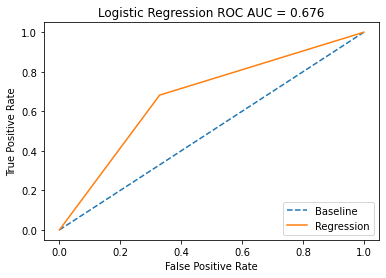

In [43]:
fpr, tpr, threshold = roc_curve(y_test, y_pred4)
roc_auc = roc_auc_score(y_test, y_pred4)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Submission

In [44]:
test_data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,date,month,weekday,weekend,no_decline,few_declines,many_declines,no_bki_request,few_bki_requests,many_bki_requests
97286,97673,14APR2014,1,1,3.332205,0,0,1.098612,1,1.578887,...,2014-04-14,4,0,0,0,0,1,0,0,1
84626,95303,11APR2014,1,1,3.496508,0,0,0.000000,0,1.126085,...,2014-04-11,4,4,0,1,0,0,0,1,0
99476,45064,21FEB2014,1,0,3.583519,0,0,0.000000,0,2.912766,...,2014-02-21,2,4,0,1,0,0,1,0,0
107676,89276,05APR2014,1,0,3.526361,0,0,0.000000,0,2.316110,...,2014-04-05,4,5,1,1,0,0,0,0,1
106806,35763,12FEB2014,1,0,4.158883,0,0,0.000000,0,2.347440,...,2014-02-12,2,2,0,1,0,0,0,1,0
90359,34281,10FEB2014,3,0,4.060443,0,0,0.000000,1,1.862948,...,2014-02-10,2,0,0,1,0,0,1,0,0
102088,2232,07JAN2014,1,0,3.555348,0,0,0.000000,0,2.770971,...,2014-01-07,1,1,0,1,0,0,0,1,0
106525,2612,08JAN2014,3,1,3.931826,1,1,0.000000,0,1.857594,...,2014-01-08,1,2,0,1,0,0,0,1,0
77094,8094,15JAN2014,1,0,4.110874,0,0,0.000000,1,1.834462,...,2014-01-15,1,2,0,1,0,0,1,0,0
99482,60319,09MAR2014,2,0,3.465736,0,0,0.000000,0,1.262624,...,2014-03-09,3,6,1,1,0,0,0,1,0


In [45]:
X_test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])

In [55]:
sample_submission=test_data['client_id']

sample_submission = pd.DataFrame(test_data['client_id'])


In [56]:
sample_submission

,client_id
73799,74835
73800,17527
73801,75683
73802,26883
73803,28862
...,...
110143,83775
110144,106254
110145,81852
110146,1971


In [47]:
predict_submission = model.predict(X_test)

In [48]:
predict_submission

array([0., 1., 0., ..., 1., 1., 1.])

In [57]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
73799,74835,0.0
73800,17527,1.0
73801,75683,0.0
73802,26883,0.0
73803,28862,0.0
73804,99881,1.0
73805,26630,1.0
73806,79934,0.0
73807,16605,0.0
73808,105449,0.0


In [58]:
sample_submission

,client_id,default
73799,74835,0.0
73800,17527,1.0
73801,75683,0.0
73802,26883,0.0
73803,28862,0.0
...,...,...
110143,83775,1.0
110144,106254,0.0
110145,81852,1.0
110146,1971,1.0
